In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.5 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count()/2)




In [ ]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, data_dir='./data', batch_size = BATCH_SIZE, num_workers=NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307), (0.3081))
        ]
    )
  def prepare_data(self):
    MNIST(self.data_dir, train=True, download=True)
    MNIST(self.data_dir, train=False, download=True)

  def setup(self, stage=None):
    # Assign train/val dataset
    if stage=="fit" or stage is None:
      mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
      self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
    # Assign test dataset
    if stage=="test" or stage is None:
      self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)




In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    #simple CNN
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.conv2(x) # Get the output of conv2
    x = self.conv2_drop(x) # Apply dropout
    x = F.relu(F.max_pool2d(x, 2)) #Apply max pooling
    # flatten the layer so it can be fed to fc layer
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)

In [ ]:
class generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.lin1 = nn.Linear(latent_dim, 7*7*64)
    self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
    self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
    self.conv = nn.Conv2d(16, 1, kernel_size=7)

  def forward(self, x):
    # Pass latent layer into linear layer and reshape
    x = self.lin1(x)
    x = F.relu(x)
    x = x.view(-1, 64, 7, 7)

    # Upsample (transposed convolution)  16 x 16 (64 feature maps)
    x = self.ct1(x)
    x = F.relu(x)

    # Upsample to 34 x 34 (16 feature maps)
    x = self.ct2(x)
    x = F.relu(x)

    # convolution to 28 x 28 (1 feature map)
    return self.conv(x)

In [ ]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, lr=0.0002):
    super().__init__()
    self.save_hyperparameters()
    self.automatic_optimization = False # Add this line
    self.generator = generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx): # Remove optimizer_idx
    real_images, _ = batch

    opt_g, opt_d = self.optimizers() # Get optimizers

    # sample noise
    z = torch.randn(real_images.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_images)

    # train generator =  max log(D(G(z)))

    fake_images = self(z)
    y_hat = self.discriminator(fake_images)

    y = torch.ones(real_images.size(0), 1)
    y = y.type_as(real_images)

    g_loss = self.adversarial_loss(y_hat, y)

    log_dict = {'g_loss': g_loss}

    opt_g.zero_grad() # zero grad for generator optimizer
    self.manual_backward(g_loss) #calculate gradients
    opt_g.step() #update generator weights

    # TRAIN DISCRIMINATOR = max log (D(x)) + log (1 - D(G(z)))

    # how well it can label as real
    y_hat_real = self.discriminator(real_images)
    y_real = torch.ones(real_images.size(0), 1)
    y_real = y_real.type_as(real_images)

    real_loss = self.adversarial_loss(y_hat_real, y_real)

    # how well it can label as fake
    y_hat_fake = self.discriminator(self(z).detach())
    y_fake = torch.zeros(real_images.size(0), 1)
    y_fake = y_fake.type_as(real_images)

    fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

    d_loss = (real_loss + fake_loss) / 2

    log_dict = {'d_loss': d_loss}

    opt_d.zero_grad() # zero grad for discriminator
    self.manual_backward(d_loss) # calculate gradients
    opt_d.step() # update discriminator weights
    return {"loss":d_loss, "progress_bar":log_dict ,  "log":log_dict} # return the discriminator loss since its the last to be calculated.


  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)

    return [opt_g, opt_d], []

  def plot_image(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)

    sample_images = self(z).detach().cpu()

    print('epoch', self.current_epoch)
    fig = plt.figure()
    for i in range(sample_images.size(0)):
      plt.subplot(2, 3, i+1)
      plt.tight_layout()
      plt.imshow(sample_images[i][0], cmap='gray_r', interpolation='none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
    plt.show()

  def on_train_epoch_end(self):
    self.plot_image()

In [ ]:
dm = MNISTDataModule()
model = GAN()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modul

Training: |          | 0/? [00:00<?, ?it/s]

epoch 0


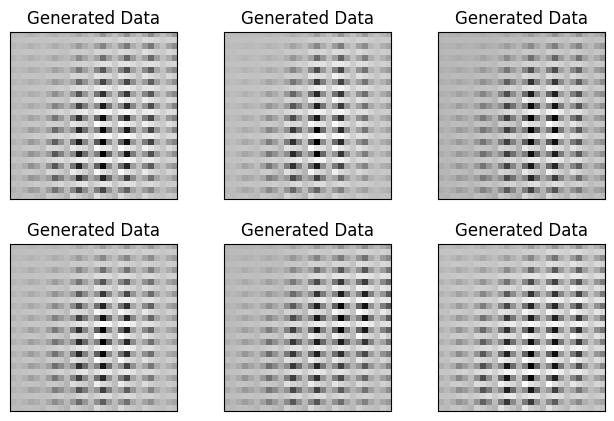

epoch 1


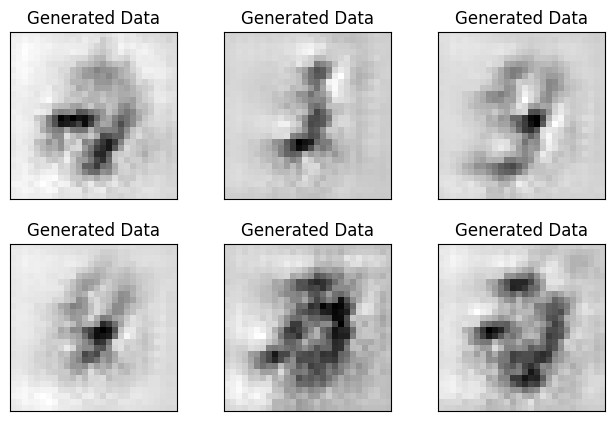

epoch 2


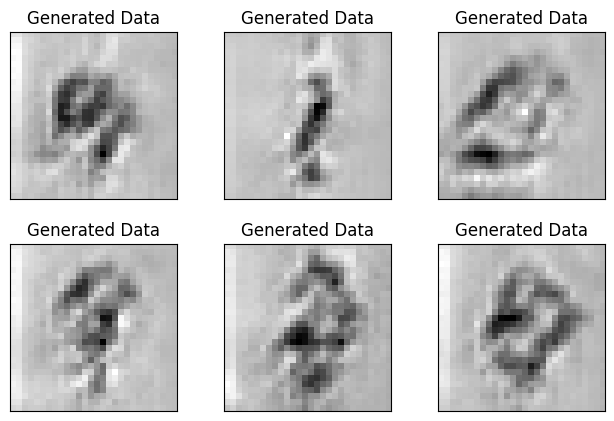

epoch 3


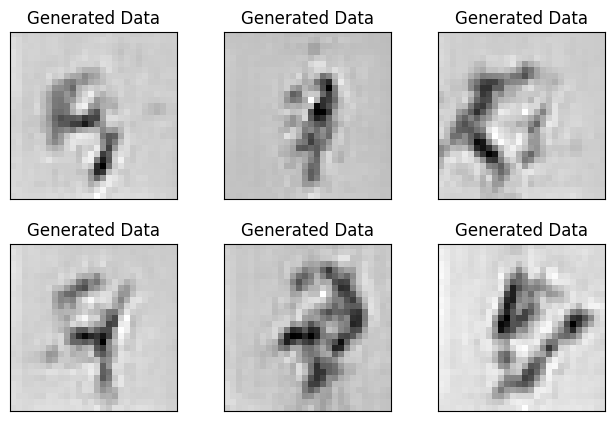

epoch 4


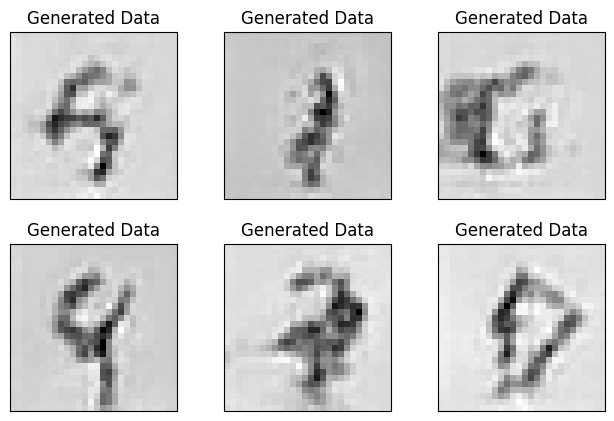

epoch 5


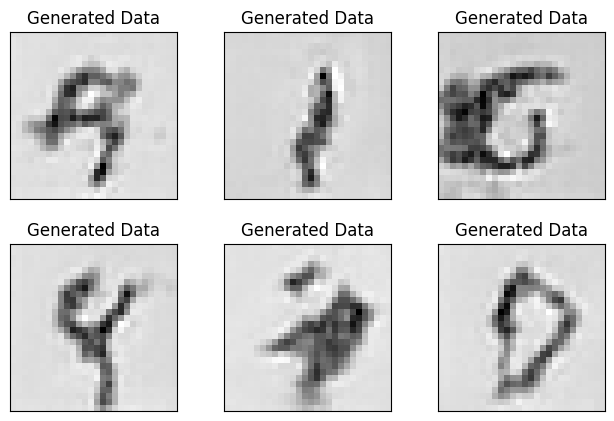

epoch 6


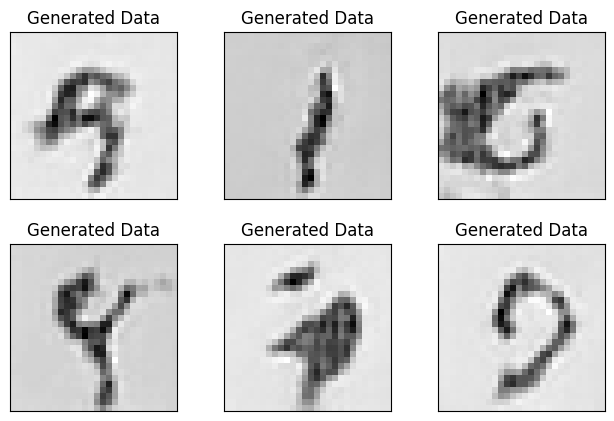

epoch 7


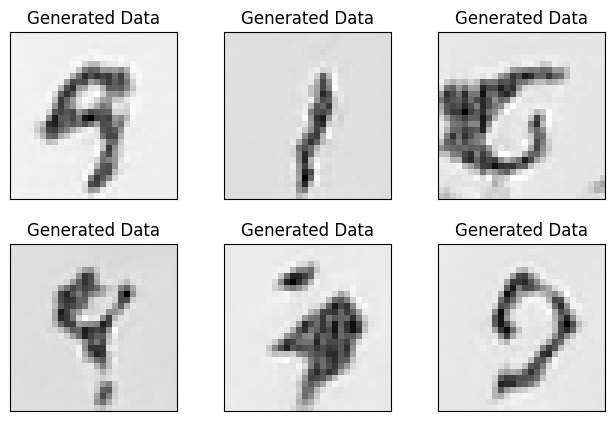

epoch 8


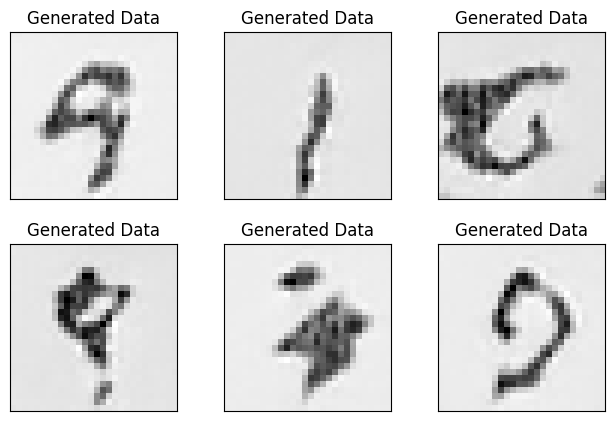

epoch 9


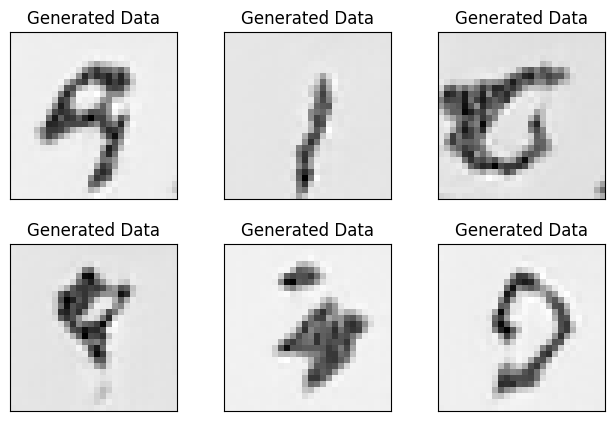

epoch 10


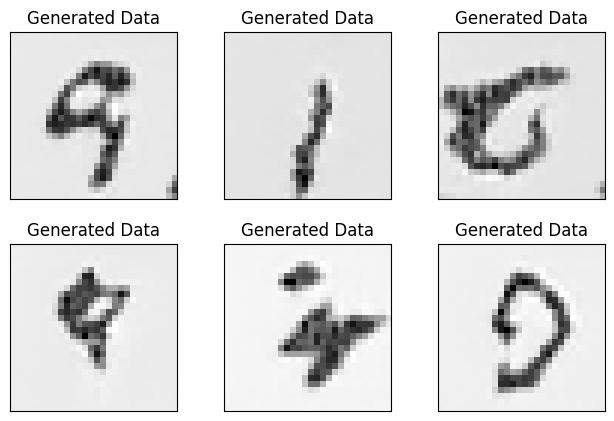

epoch 11


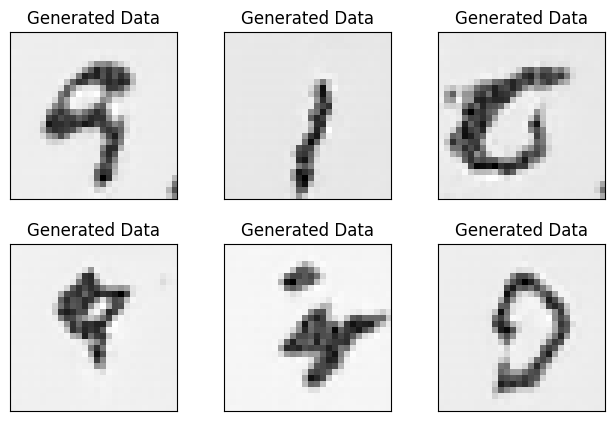

epoch 12


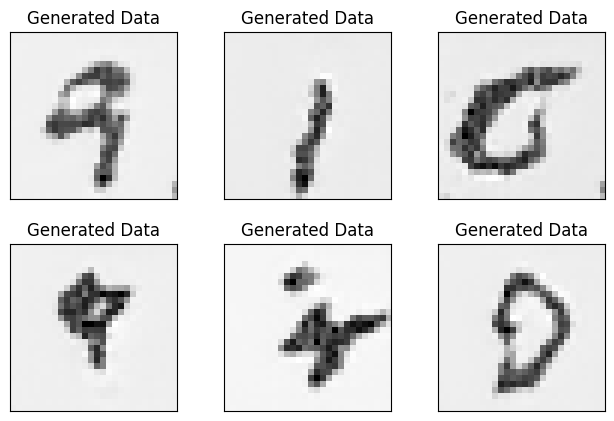

epoch 13


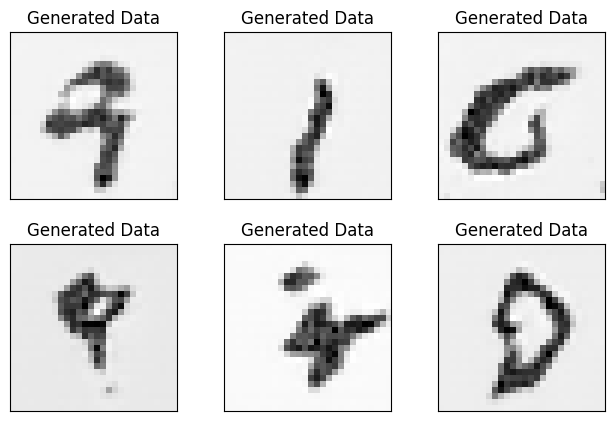

epoch 14


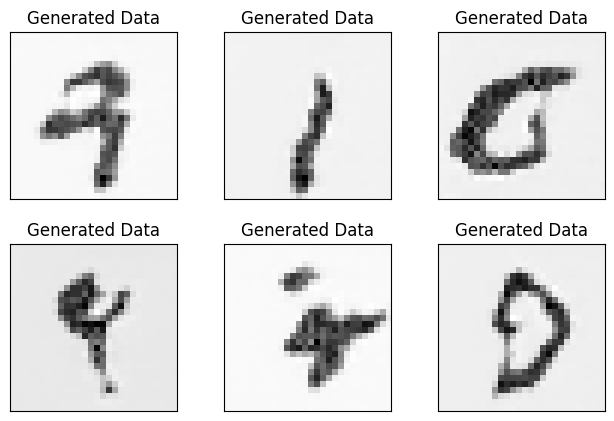

epoch 15


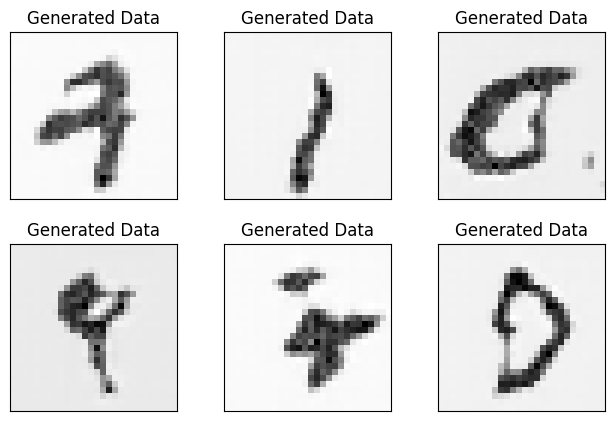

epoch 16


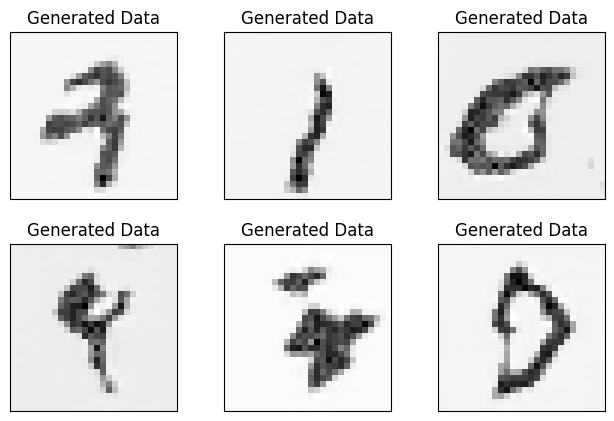

epoch 17


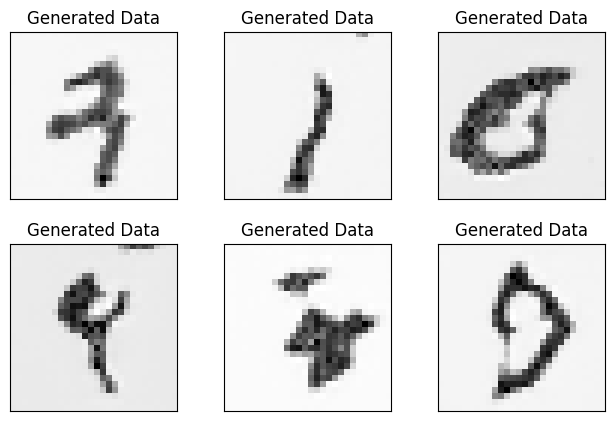

epoch 18


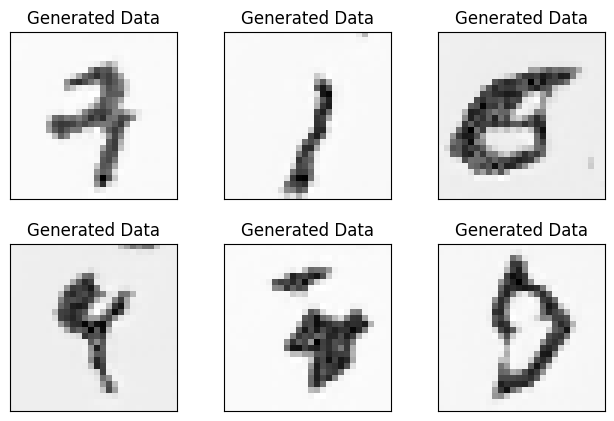

epoch 19


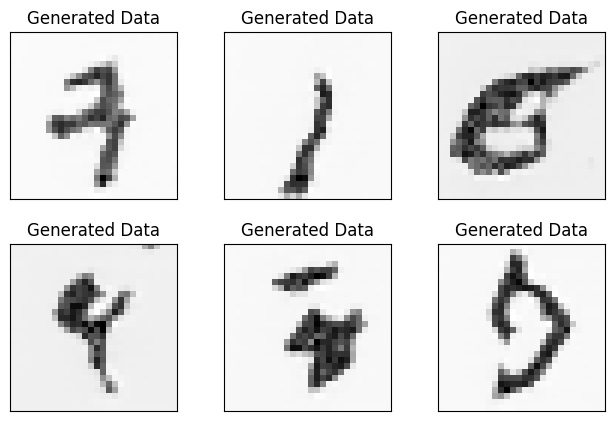

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)